In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

Installed watermark.py. To use it, type:
  %load_ext watermark


In [3]:
%load_ext watermark

In [4]:
%watermark -a "Chandra I am using Python 3.4" -d -v -m

Chandra I am using Python 3.4 10/05/2015 

CPython 3.4.1
IPython 3.1.0

compiler   : MSC v.1600 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [5]:
import pandas as pd
import subprocess
import os
from datetime import date
from datetime import timedelta
import numpy as np
import sys
from sklearn.linear_model import ElasticNet
from collections import OrderedDict
from sklearn.neighbors.kde import KernelDensity

In [6]:
import brewer2mpl
import matplotlib.pyplot as plt
import random
from sklearn.cross_validation import KFold

In [7]:
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
%matplotlib inline

# Initial Problem:
    

* Objective: Predict units sold given a date (and associated weather), store and item number
* Units are Weather-sensitive items
* Test Set + Training Set is a 3 year span of sales for Walmart
   * Test set includes days within $\pm$ 3 days of a major Storm, which we'll call "stormy days"
   * Test set includes only days within the final year(?)
   * Test set is not all stormy days in that time period
   * Training set is all remaining days
* Other issues:
   * There are some missing values in weather, indicated by 'M' (there are also "trace" amounts indicated by 'T'. These need to  be  filled on (with imputation if yes what logic?).
   * The test set and training set are fundamentally different. The training set includes days not qualified as "stormy days" whereas the test set does not.
   * There may be other trends such as time.
   * we are unable to track items across different stores, because item numbers are randomized for each store.

### Overview:

* View datasets
* Analysis of missingness ('M' and 'T' values)
* Imputation using split-apply-combine techniques
* Categorize stormy days
* Look at sales trends by store, item, date (dataviz)
* Inspect 0-sales day
* Build features
* Run Models

#### Go to the Current Working Directory

In [8]:
import os 
os.chdir(r"C:\Users\cdron\Desktop\Cleanup\Misc\kaggle\Walmart_Weather")
os.getcwd()

'C:\\Users\\cdron\\Desktop\\Cleanup\\Misc\\kaggle\\Walmart_Weather'

## As a first logical step lets look at the features of the data we have to work with...

In [9]:
weather= pd.read_csv('weather.csv')
print (weather.shape)
weather.head(3)

(20517, 20)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0


In [10]:
train = pd.read_csv('train.csv')
print (train.shape)
train.head(3)

(4617600, 4)


,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0


In [11]:
test = pd.read_csv('test.csv')
print (test.shape)
test.head(3)

(526917, 3)


,date,store_nbr,item_nbr
0,2013-04-01,2,1
1,2013-04-01,2,2
2,2013-04-01,2,3


In [12]:
def fix_date(x):
    x = x.split('-')
    return date(int(x[0]), int(x[1]), int(x[2]))

for df in [weather, test, train]:
    df.loc[:, 'date'] = df.loc[:, 'date'].apply(lambda x:fix_date(x))

In [13]:
date(2014,10,26) - date(2012,1,1)

datetime.timedelta(1029)

In [14]:
month_days = {1: 0,
            2: 31,
            3: 59,
            4: 90,
            5: 120,
            6: 151,
            7: 181,
            8: 212,
            9: 243,
            10: 273,
            11: 303,
            12: 334}

def convert_date(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date (2012, 2, 29):
        return month + day
    else: 
        return 1 + year*365 + month + day

train_dates = train.date.apply(lambda x: convert_date(x))

In [15]:
test_dates = test.date.apply(lambda x: convert_date(x))

### The test and training sets combine to make a full set of sales for 111 items in 45 stores spanning from 01/01/2012 to 10/26/2014. The Test set includes only days after 04/01/2013, within $\pm$ of a day they characterize as storm

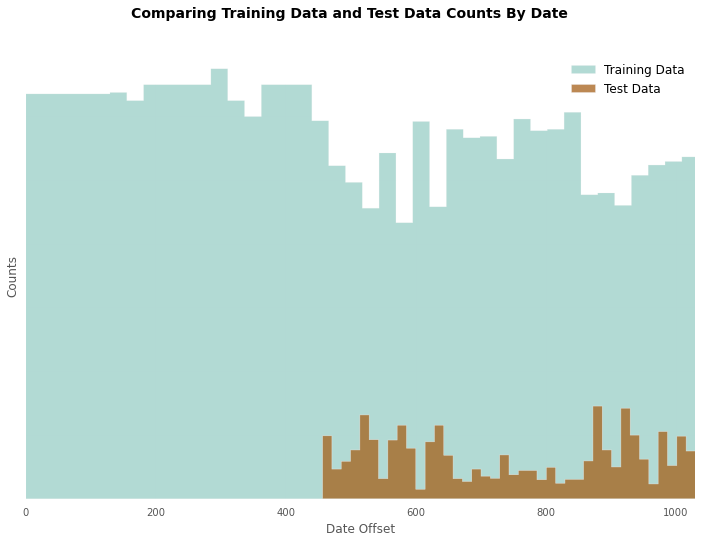

In [16]:
fig = plt.figure(figsize = (12,8)) 
ax = fig.add_subplot(1,1,1)
colors = brewer2mpl.get_map('BrBG','diverging',4).mpl_colors 

tr = plt.hist(train_dates, bins = 40, color = colors[3], normed = False, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Training Data')
te = plt.hist(test_dates, bins = 40, color = colors[0], normed = False, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.75, label = 'Test Data')
for label in ax.get_xticklines():
    label.set_visible(False)
for label in ax.get_yticklines():
    label.set_visible(False)
for label in ax.get_yticklabels():
    label.set_visible(False)  
x = plt.xlim([0,1029])
plt.xlabel('Date Offset')
plt.ylabel('Counts')
ax.legend(loc = 'best')
plt.suptitle('Comparing Training Data and Test Data Counts By Date', 
             fontsize = 14, fontweight = 'bold')
plt.show()

Key to join weather station with store

In [17]:
key= pd.read_csv('key.csv', index_col='store_nbr')
key.head()

,station_nbr
store_nbr,
1,1
2,14
3,7
4,9
5,12


Sample submission - this is what the final output needs to look like 

In [18]:
sample_submit = pd.read_csv('sampleSubmission.csv', index_col = 'id')
sample_submit.head()

,units
id,
2_1_2013-04-01,0
2_2_2013-04-01,0
2_3_2013-04-01,0
2_4_2013-04-01,0
2_5_2013-04-01,0


# Initial Prep of datasets

- Join key with test and training set
- Add store_item_date id to test set
- Convert dates to python dates

In [19]:
train = train.merge(key, left_on='store_nbr', right_index=True)
test = test.merge(key, left_on='store_nbr', right_index=True)

In [20]:
test.loc[:, 'id']= test.store_nbr.apply(lambda x:str(x))+ '_'+\
                   test.item_nbr.apply(lambda x:str(x)) + '_' +\
                   test.date.apply(lambda x: str(x))

# Plot of Station counts by store

In [21]:
station_counts=train[['station_nbr', 'store_nbr']].drop_duplicates().groupby('station_nbr').count()
station_counts=[station_counts.loc[c][0] if c in station_counts.index else 0 for c in np.arange(1,21,1)]

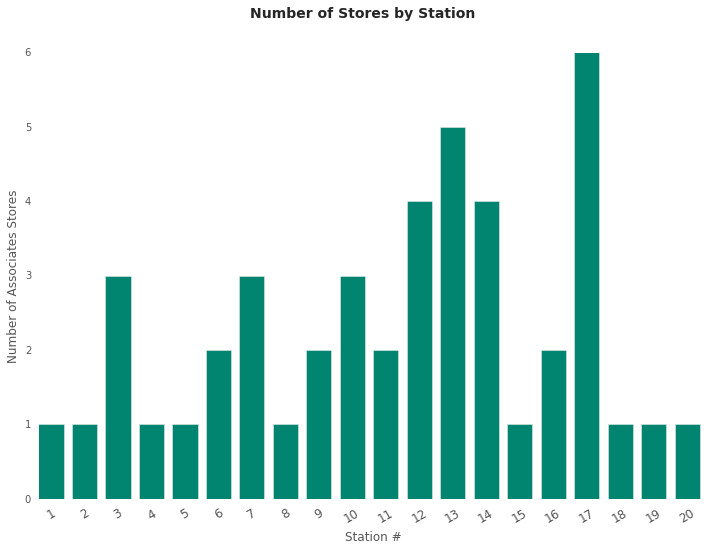

In [22]:
fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)

x = np.arange(1,21,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x, station_counts, width, color = colors[3])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,x, rotation = 30, fontsize = 12)
plt.xlabel('Station #')
plt.ylabel('Number of Associates Stores')
plt.suptitle('Number of Stores by Station', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])
plt.show()

# Station 5 is not associated with any stores so we can throw it away

In [23]:
print (test[['date', 'station_nbr']].groupby('station_nbr').count().index)

Int64Index([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')


In [24]:
print (train[['date', 'station_nbr']].groupby('station_nbr').count().index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')


In [25]:
train = train[train.station_nbr!=5]
weather = weather[weather.station_nbr!=5]

# Weather Data Set

There are 'T' values for trace, meaning small amount. We'll replace that with the half the smallest non-zero value for that column.

- 'Departure' is missing 56% of values. This may be unusable but if we can get data from surrounding days we can recover a lot of average temperatures.
- 'Snowfall' is missing 35% of values. This could be a key column so we should take more care in imputing it.
- The others are missing 8% or fewer.

### We will use the following steps to impute as many missing values as possible. Each step fills in some missing values, but others remain missing. For those still missing, we loosen the restrictions. Since 'Depature' and 'Snowfall' are missing so many values (35% and 56%, respectively), we'll look at those seperately

* Calculate the average value for that measure within a $\pm$ 3 day window for that station.
* Calculate the average value for that measure within a $\pm$ 5 day window for that station.
* Calculate the average value for that measure within a $\pm$ 15 day window for that station.
* If that still fails, calculate the store average for that month and day of week for all years.
* At this point, we determine that we cannot reasonable replace the missing value and we leave it as null.

### Codesum T is just a code (not trace). We will not get the minimum for snowfall and preciptotal and replace 'T' with that value.

In [34]:
for col in ['snowfall','preciptotal']:
    # temporarily replace with -1
    v = weather.loc[:, col].apply(lambda x: -1. if str(x).strip() in ['M', 'T'] else float(x))
    # replace 'T' with the minimum non-zero value
    weather.loc[:, col] = weather.loc[:, col].apply(lambda x: v[v > 0].min() if str(x).strip() == 'T' else x)

In [36]:
print (len(weather[weather.snowfall == 'T']))
print (len(weather[weather.preciptotal == 'T']))

0
0


In [37]:
icols = ['station_nbr']

In [38]:
icols.extend(['tavg', 'resultdir', 'stnpressure', 'tmin', 'wetbulb', 'dewpoint', 'avgspeed', 'tmax', 'sealevel', 'heat', 'preciptotal', 'resultspeed', 'cool'])

In [39]:
print (icols)

['station_nbr', 'tavg', 'resultdir', 'stnpressure', 'tmin', 'wetbulb', 'dewpoint', 'avgspeed', 'tmax', 'sealevel', 'heat', 'preciptotal', 'resultspeed', 'cool']


In [40]:
for c in [c for c in icols if c != 'store_nbr']:
    weather.loc[:, c] = weather.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))

In [41]:
# pm_weather takes a row from a df, a dict w
# and number of days offset, and adds a row to d
# for each date and corresponding values from the 
# df row
# ultimately, this lets us average the values from
# a window around a target day

def pm_weather(row, w, d, icols):
    #current date
    currdate = row.date
    
    # all values for the columns we want
    vals = list(row.loc[icols].values)
    
    n = len(w)
    # make a row for +/- 3 days from this current date/station
    for day in range(-d, d+1):
        w[day + n + d]= [currdate + timedelta(days= day)]
        w[day + n + d].extend(vals)
    return w

In [ ]:
# make a df of all +/- 3 day windows
def impute_vals(weather, window):
    wimpute={}
    
    for i in weather.index:
        wimpute= pm_weather(weather.loc[i, :], wimpute, 3, icols)
    impute = DataFrame.from_dict(wimpute, orient='index')
    wcols = ['date']
    wcols.extend(icols)
    impute.columns= wcols
    
    station_date_means= impute.groupby(['date','station_nbr']).mean()
    #for each column to impute
    for col in list(missin)